In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.optimize as optimize

# Step 0: Web scrap price data
symbols = ['MSFT', 'AAPL', 'NVDA', 'LRCX', 'AMZN', 'GOOGL', 'TSLA']
start_date = '2015-03-21'
end_date = '2022-02-01'

prices_df = pd.DataFrame()
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date)
    prices_df[symbol] = df['Close']

# Step 1: Optimize portfolio weights
def sharpe_ratio(weights, returns, risk_free_rate):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio

def m_drawdown(weights, returns, max_drawdown):
    portfolio_returns = np.dot(returns, weights)
    cum_returns = np.cumprod(portfolio_returns + 1)
    max_drawdown_value = np.max(np.maximum.accumulate(cum_returns) - cum_returns) / np.max(cum_returns)
    return max_drawdown_value - max_drawdown

def optimize_weights(returns, risk_free_rate, max_drawdown):
    num_assets = returns.shape[1]
    initial_weights = np.array([1/num_assets]*num_assets)
    bounds = tuple((0, 1) for i in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: m_drawdown(x, returns, max_drawdown)})
    result = optimize.minimize(sharpe_ratio, initial_weights, args=(returns, risk_free_rate), bounds=bounds, constraints=constraints)
    return result.x

risk_free_rate = 0.02 # assuming a constant risk-free rate of 2%
max_drawdown_constraint = 0.2 # max drawdown constraint of 20%

returns_df = prices_df.pct_change().dropna()
optimized_weights = optimize_weights(returns_df, risk_free_rate, max_drawdown_constraint)
print('Optimized weights for the portfolio that consists of')
print('MSFT, AAPL, NVDA, LRCX, AMZN, GOOGL, TSLA are')
print(optimized_weights)

portfolio_df = prices_df.dot(optimized_weights)

Optimized weights for the portfolio that consists of
MSFT, AAPL, NVDA, LRCX, AMZN, GOOGL, TSLA are
[2.20456601e-01 0.00000000e+00 3.99232985e-01 4.33680869e-17
 1.90550435e-01 0.00000000e+00 1.89759979e-01]


In [45]:
# Step 2: Compute daily return of the portfolio
returns_df = portfolio_df.pct_change().dropna()

# Step 3: Model the portfolio return PDF by the Pearson system
pearson_params = stats.pearson3.fit(returns_df)

# Step 4: Generate 1000 samples from the model
samples = stats.pearson3.rvs(*pearson_params, size=1000)

/tmp/ipykernel_3572068/1734225667.py:7: RuntimeWarning: invalid value encountered in log
  g = np.sum(np.log(1 + f*samples))/len(samples)


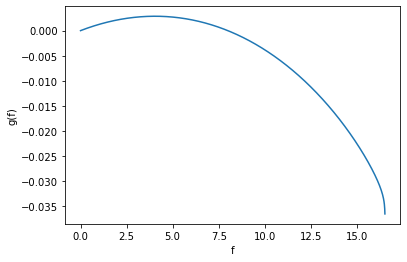

The optimal leverage:  4.04


In [46]:
# Step 5: Plot g(f)
f_values = np.arange(0, 21, 0.01)
g_values = []
g_max=float('-inf')
f_max=-1
for f in f_values:
    g = np.sum(np.log(1 + f*samples))/len(samples)
    if g>g_max:
        g_max=g
        f_max=f
    g_values.append(g)

plt.plot(f_values, g_values)
plt.xlabel('f')
plt.ylabel('g(f)')
plt.show()
print('The optimal leverage: ',f_max)